# PatchCore Example

#### Import dependencies

In [1]:
import image_anomaly_detection as iad

import torch
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

# 

## Training

#### Load dataset

In [18]:
class_name = 'bottle'
data_path = '../../data/mvtec_dataset/' # Path to mvtec dataset
dataset = iad.MVTecDataset(data_path, class_name=class_name, is_train=True)
dataloader = DataLoader(dataset, batch_size=32, pin_memory=True)
print("Number of images in dataset:", len(dataset))

Number of images in dataset: 209


#### Init the model

In [19]:
patch_core = iad.PatchCore(torch.device('cpu'), 'resnet18')

#### Fit the model to the dataset

In [20]:
patch_core.fit(dataloader)

Feature extraction: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Getting transformed features...
Calculating distances...
Maximum distance from cluster centers is 2.10


#### Save the necessary parameters

In [5]:
distributions_path = '../distributions/'
torch.save(patch_core.embedding_coreset, distributions_path+'bottle_embedding_coreset.pt')

# 

## Inference
#### Load test images

In [2]:
paths = [
    '../../data/mvtec_dataset/bottle/test/broken_large/000.png',
    '../../data/mvtec_dataset/bottle/test/broken_small/000.png',
    '../../data/mvtec_dataset/bottle/test/contamination/000.png',
    '../../data/mvtec_dataset/bottle/test/good/000.png',
    '../../data/mvtec_dataset/bottle/test/good/001.png',
]

images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

#### Load the necessary parameters

In [3]:
distributions_path = '../distributions/'
embedding_coreset = torch.load(distributions_path+'bottle_embedding_coreset.pt')

#### init the model

In [8]:
patch_core = iad.PatchCore(torch.device('cpu'), 'resnet18', embedding_coreset=embedding_coreset)

#### Make prediction

In [9]:
patch_scores = patch_core.predict(images)

#### Interpret the prediction

In [10]:
patch_scores_blurred = torchvision.transforms.GaussianBlur(7, sigma=2)(patch_scores

In [13]:
THRESH = 2.0
patch_classifications = iad.patch_classification(patch_scores_blurred, THRESH)
image_scores = iad.image_score(patch_scores_blurred)
image_classifications = iad.image_classification(image_scores, THRESH)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([3.1803, 2.0515, 2.7872, 1.6167, 1.6166])
Image classifications: tensor([0., 0., 0., 1., 1.])


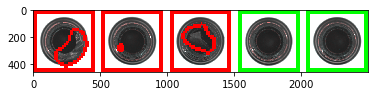

In [14]:
img = iad.boundary_image_classification_group(images, patch_classifications, image_classifications, 400)
plt.imshow(img)
plt.show()

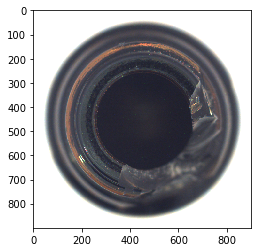

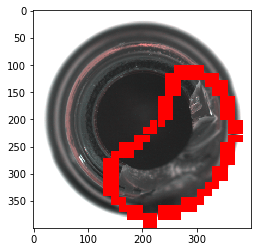

In [21]:
idx = 0
img = iad.boundary_image(images[idx], patch_classifications[idx], 400)
plt.imshow(images[idx])
plt.show()
plt.imshow(img)
plt.show()